# < CIFAR-10 이미지 생성하기 >

**- 목차 -**

□ Step0 작업환경 구성하기   
□ Step1 데이터셋 구성하기   
□ Step2 생성자 모델 구현하기   
□ Step3 판별자 모델 구현하기   
□ Step4 손실함수와 최적화 함수 구현하기    
□ Step5 훈련과정 상세 기능 구현하기   
□ Step6 학습 과정 진행하기   
□ Step7 GAN 훈련 과정 개선하기(1) - epochs 300 추가   
□ Step8 GAN 훈련 과정 개선하기(2) - learning rate 증가 / epochs 50 추가   
□ Step9 GAN 훈련 과정 개선하기(3) - Layer 추가 / epochs 50 추가   
□ 정리 및 회고

### ■ Step0 작업환경 구성하기

**0-0 폴더 생성**

In [2]:
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

**0-1 필요한 라이브러리 import**

In [3]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


### ■ Step1 데이터셋 구성하기

**1-1 데이터 로드**

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print("shape:", train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

170500096/170498071 [==============================] - 2s 0us/step
shape: (50000, 32, 32, 3)
max pixel: 255
min pixel: 0


**1-2 train_x 이미지 -1, 1로 정규화**

In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


**1-3 데이터 시각화**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


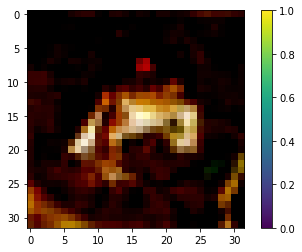

In [7]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

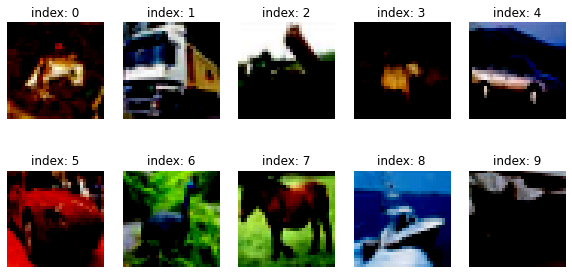

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

**1-4 미니배치 데이터셋 구성**

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

### ■ Step2 생성자 모델 구현하기

**2-1 생성자 모델 함수 정의**

In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

- (8, 8, 256) -> (16, 16, 64) -> (32, 32, 3)

**2-2 생성자 모델 summary 확인**

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

**2-3 노이즈 벡터 생성**

In [12]:
noise = tf.random.normal([1, 100])

**2-4 이미지 생성**

In [13]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

**2-5 이미지 확인**

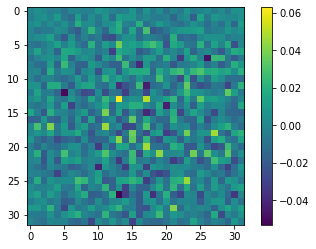

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### ■ Step3 판별자 모델 구현하기

**3-1 판별자 모델 함수 정의**

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

- (32, 32, 3) -> (16, 16, 64) -> (8, 8, 128)

**3-2 판별자 모델 summary 확인**

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

**3-3 생성자가 만든 가짜 이미지를 판별자에 입력하고 결과 확인**

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00375174]], dtype=float32)>

### ■ Step4 손실함수와 최적화 함수 구현하기

**4-1 BinaryCrossentropy로 손실함수(loss) 준비**

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**4-2 생성자 손실함수 정의**

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

**4-3 판별자 손실함수 정의**

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

**4-4 판별자 정확도 계산 함수 정의**

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

**4-5 Adam으로 최적화 함수(optimizer) 준비**

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**4-6 학습 진전 과정 확인용 샘플 생성**

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### ■ Step5 훈련과정 상세 기능 구현하기

**5-1 `train_step()` 함수 정의**

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

**5-2 `generate_and_save_images()` 함수 정의**

In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

**5-3 `draw_train_history` 시각화 함수 정의**

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

**5-4 정기적으로 모델을 저장하기 위한 checkpoint 만들기**

In [27]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### ■ Step6 학습 과정 진행하기

**6-1 `train` 함수 정의**

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

**6-2 모델 저장 간격(save_every)과 전체 학습 에포크(EPOCHS) 파라미터 설정**

In [66]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**6-3 모델 학습**

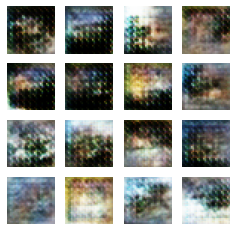

Time for training : 1512 sec


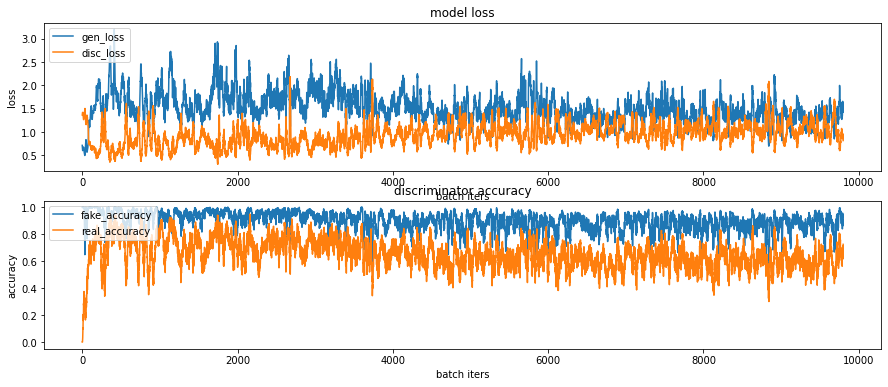

CPU times: user 19min 8s, sys: 6min 18s, total: 25min 27s
Wall time: 25min 13s


In [67]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성
# 진행 과정을 수시로 확인해 보시길 권함

**6-4 학습과정 시각화하기**

In [29]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1294962 Nov 16 06:21 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


### ■ Step7 GAN 훈련 과정 개선하기(1) - epochs 300 추가

**7-1 checkpoint 모듈을 활용하여 모델을 로드**

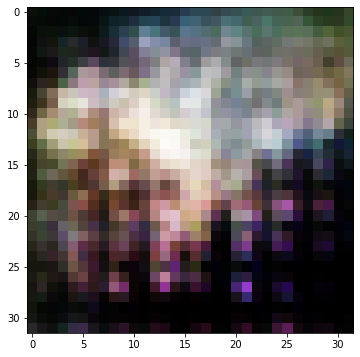

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

**7-2 epochs 300으로 증가하여 다시 학습**

In [31]:
save_every = 5
EPOCHS = 300

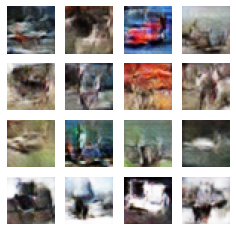

Time for training : 9320 sec


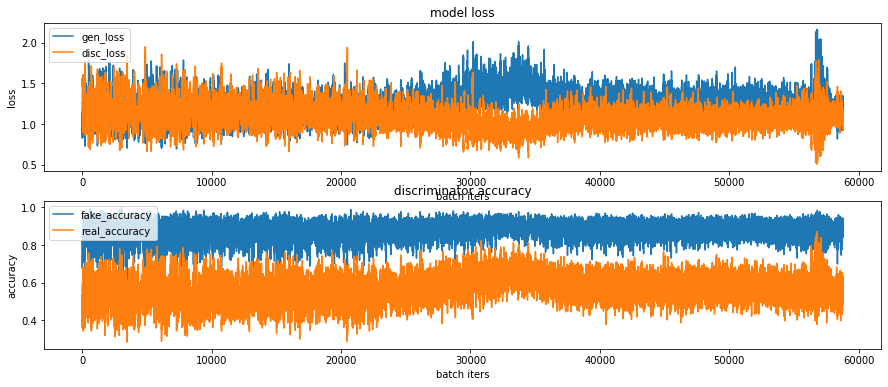

CPU times: user 2h 51s, sys: 37min 19s, total: 2h 38min 10s
Wall time: 2h 35min 24s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)

**7-3 학습과정 시각화하기**

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_epochs300.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_epochs300.gif

-rw-r--r-- 1 root root 3079131 Nov 16 08:59 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_epochs300.gif


### ■ Step8 GAN 훈련 과정 개선하기(2) - learning rate 증가 / epochs 50 추가

**8-1 checkpoint 모듈을 활용하여 모델을 로드**

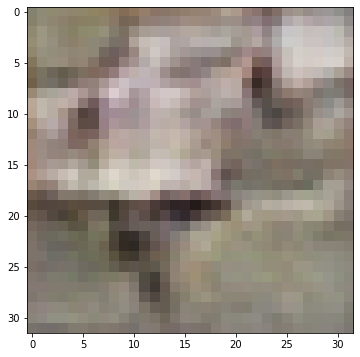

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

**8-2 adam optimizer의 learning rate 향상시켜 다시 학습**

In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)
save_every = 5
EPOCHS = 50

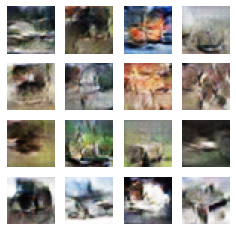

Time for training : 1509 sec


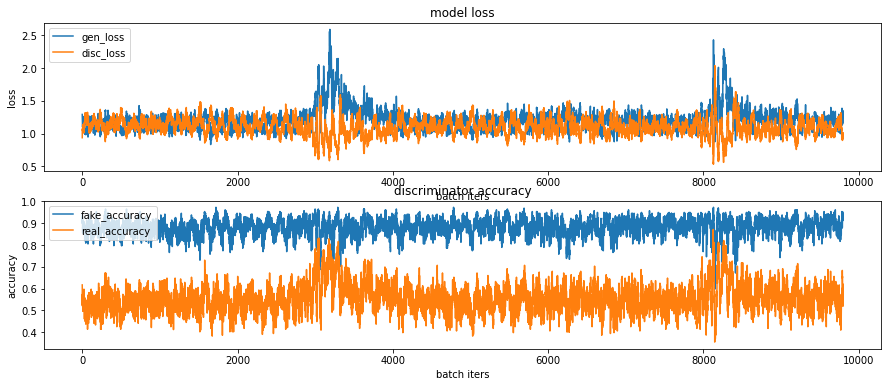

CPU times: user 19min 27s, sys: 6min 10s, total: 25min 38s
Wall time: 25min 10s


In [36]:
%%time
train(train_dataset, EPOCHS, save_every)

**8-3 학습과정 시각화하기**

In [37]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif

-rw-r--r-- 1 root root 3042399 Nov 16 09:46 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif


### ■ Step9 GAN 훈련 과정 개선하기(3) - Layer 추가 / epochs 50 추가

**9-1 checkpoint 모듈을 활용하여 모델을 로드**

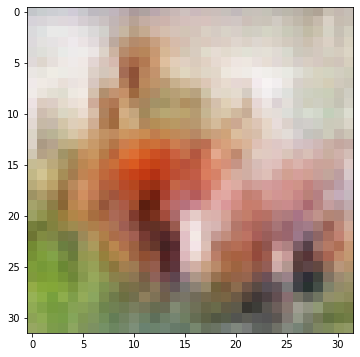

In [38]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

**9-2 판별자 모델 Conv2D Layer 추가하여 학습**

In [39]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Add: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [40]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)        

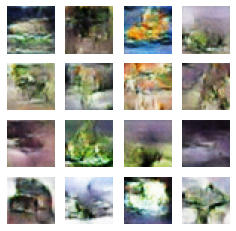

Time for training : 1508 sec


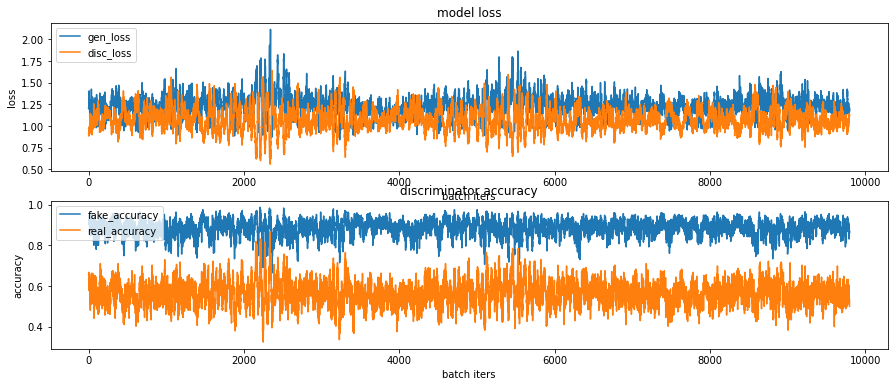

CPU times: user 19min 24s, sys: 6min 12s, total: 25min 37s
Wall time: 25min 9s


In [42]:
%%time
train(train_dataset, EPOCHS, save_every)

**9-3 학습과정 시각화하기**

In [43]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_4.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_4.gif

-rw-r--r-- 1 root root 3039689 Nov 16 12:58 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_4.gif


### ■ 정리 및 회고

**1. 첫 학습 EPOCHS = 50**

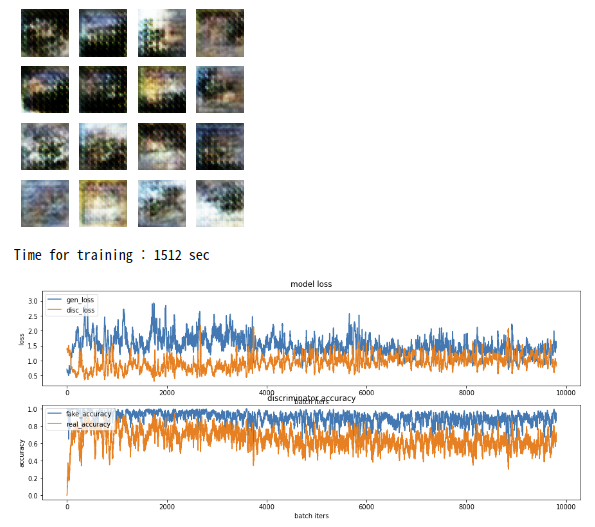

**2. EPOCHS = 300 추가**

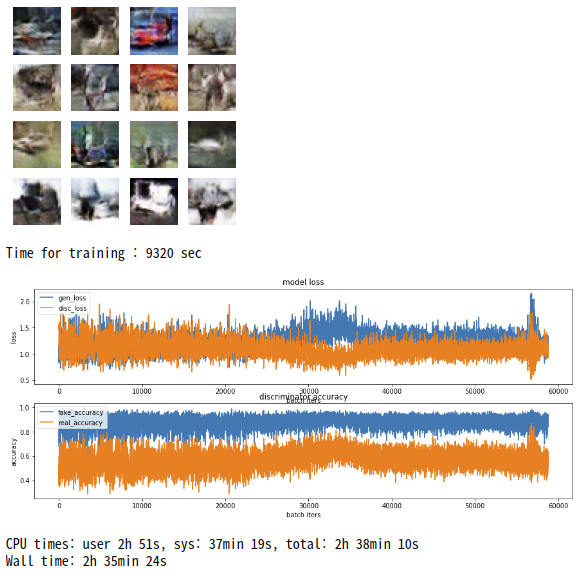

**3. learning rate 증가 / epochs 50 추가**

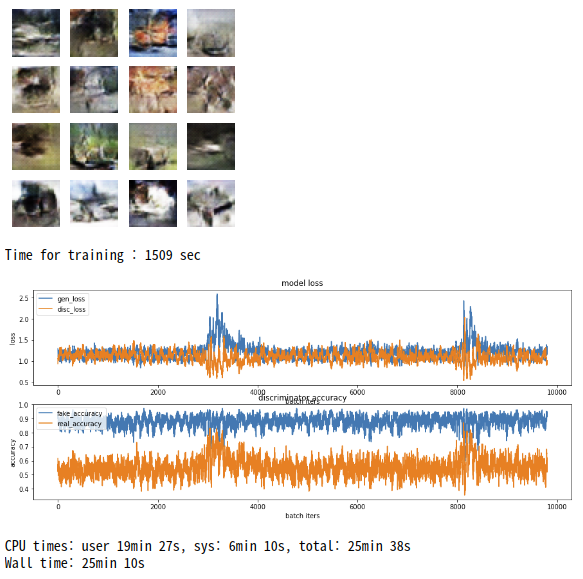

**4. 판별자 모델 Conv2D Layer 추가 / epochs 50 추가**

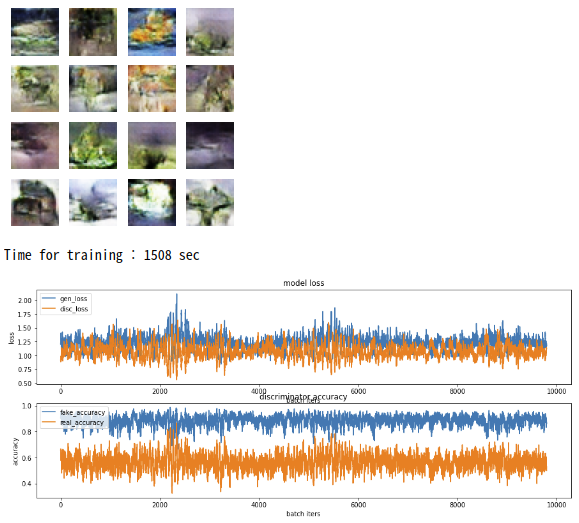

- 처음 epochs이 50일 때는 생성된 이미지가 거의 무엇인지 알아보기 어려울 정도였으나, epochs을 300 추가한 뒤에는 컬러도 선명해지고 이미지에서 조금씩 특정 사물, 동물 등이 보이기 시작했다.


- 또한 learning rate 증가를 증가시키고, 판별자 모델의 layer를 증가 시키니 fake_accuracy와 real_accuray 그래프가 0.5 부근으로 향하는 모습을 보여주었다.


- GAN이라는 새로운 모델을 알게 되어 흥미로웠으나, 개념을 이해하고 구현하는게 쉽지는 않았다. 학습시간이 상당히 오래 걸려 더 다양한 방법으로 성능을 개선시켜보지 못해 아쉽다.GAN에 대해 보다 자세히 이해하고 성능을 개선시키는 방법들도 체계적으로 정리해보아야겠다.